### Import Packages and Reading of Data

In [159]:
import time
import warnings
import pickle

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedKFold
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline


pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [132]:
# Reading of Excel
dataset = pd.read_csv('cleaned_others_dataset.csv')

In [133]:
dataset

,verified,location,followers_count,following_count,tweet_count,isFraud,un_no_of_char,un_special_char,un_uppercase,name_no_of_char,name_special_char,name_uppercase,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,0,1997,5,17090,1,15,1,0,19,0,1,2,0,0,1,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0,1,785,829,251,0,12,0,1,8,0,1,0,0,0,1,2016,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,243,1232,1469,0,8,0,1,11,0,0,0,0,0,1,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,1,1,737048,128,4739,0,13,0,1,14,0,1,1,0,0,1,2012,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,1,281703,1599,14785,0,14,0,0,16,0,1,1,0,1,1,2009,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24549,1,0,2025977,947,194749,0,11,1,0,13,0,1,1,0,0,1,2009,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
24550,1,1,367523,17291,24084,0,14,0,1,10,0,1,2,0,0,1,2009,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
24551,0,0,395,492,21437,1,14,0,1,16,0,1,0,0,0,1,2012,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
24552,0,0,159,618,3021,0,8,0,1,14,0,1,0,0,0,0,2015,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


### Feature Engineering

In [161]:
#Getting X and y
x = dataset.drop(columns = ['isFraud'])
y = dataset['isFraud']
#Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=101)
print("Train set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Train set: (19643, 35) (19643,)
Test set: (4911, 35) (4911,)


In [175]:
#We only want to scale the numeric variables and not the categorical features. Hence, we create a columntransformer to help
#us to do this
scaler = StandardScaler()

x_train[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']] = scaler.fit_transform(x_train[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']])

x_test[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']] = scaler.transform(x_test[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']])

# I commented out this cell cos the above cell does the same thing

#Turning the generated scaled matrix into a dataframe 
x_train = pd.DataFrame(X_train_fitted, columns = x_train.columns)
x_test = pd.DataFrame(X_test_fitted, columns = x_test.columns)
y_train = pd.DataFrame(y_train, columns = ["isFraud"])
y_test = pd.DataFrame(y_test, columns = ["isFraud"])

In [176]:
#Next, we need to transform the year column into one hot encodings
#Transform the year column into a categorical variable and store the result in a dataframe
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
transformed_year_train_matrix = encoder.fit_transform(x_train[['year']])
transformed_year_train = pd.DataFrame(transformed_year_train_matrix, columns = encoder.get_feature_names_out())
#using the fitted encoder to transform the test data and storing in a dataframe
transformed_year_test_matrix = encoder.transform(x_test[['year']])
transformed_year_test = pd.DataFrame(transformed_year_test_matrix, columns = encoder.get_feature_names_out())

In [177]:
#reset the index for training and testing sets to allow merging with the one hot encoded variables, drop the index column as well
x_train.reset_index(inplace = True, drop = True)
x_test.reset_index(inplace = True, drop = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [178]:
#Combine the scaled numeric variables together with the year categorical variables
x_train = pd.concat([x_train, transformed_year_train], axis = 1)
x_test = pd.concat([x_test, transformed_year_test], axis = 1)


In [179]:
#Drop the year column since we already have the dummy variables for year
x_train.drop(labels = ['year'], axis = 1, inplace = True)
x_test.drop(labels = ['year'], axis = 1, inplace = True)


In [170]:
#A class that combines all the preprocessing steps (for model pipeline purpose)
class ExperimentalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, numeric_variables = ['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']):
        self.encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
        self.scaler = StandardScaler()
        #specified numeric variables, by default it is the above
        self.numeric_variables = numeric_variables
        
    
    #The fit function that will be called when this custom transformer is fit
    def fit(self, X, y = None):
        #fit the one hot encoder to the year
        self.encoder.fit(X[['year']])
        #fit the scaler on the numeric variables
        self.scaler.fit(X[self.numeric_variables])
        return self
    
    #The transform function that will be called
    def transform(self, X, y = None):
        
        #to avoid changing the original dataset
        X_ = X.copy()
        #transforming the numeric variables according to the fitted scaler
        X_[self.numeric_variables] = self.scaler.transform(X_[self.numeric_variables])
        
        #next, create a date matrix using the fitted encoder
        transformed_year_matrix = self.encoder.transform(X_[['year']])
        #get the dataframe
        transformed_year_train = pd.DataFrame(transformed_year_matrix, columns = self.encoder.get_feature_names_out())
        #reset the index of the original dataframe
        X_.reset_index(drop = True, inplace = True)
        X_ = pd.concat([X_, transformed_year_train], axis = 1)
        #drop the year column from the dataframe
        X_.drop(labels = ['year'], inplace = True, axis = 1)
        return X_
        
        
    

# Below few cells are to test whether the pipeline class is working, can delete once done

In [171]:
pipeline = make_pipeline(ExperimentalTransformer(), RandomForestClassifier(bootstrap=True, max_depth=80, max_features='auto', min_samples_split=2, n_estimators=800))

In [172]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('experimentaltransformer', ExperimentalTransformer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=80, n_estimators=800))])

In [173]:
y_pred = pipeline.predict(x_test)

In [185]:
# Error Metrics
mae = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {mae}')
f1_score = metrics.f1_score(y_test, y_pred)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred)
print(f'Recall: {recall}')

Accuracy: 0.8639788230502953
F1-score: 0.6276477146042365
Precision: 0.8065902578796562
Recall: 0.5136861313868614


### Charts

In [7]:
#A function to plot the feature importance as given in the RandomForestClassifer class
def feature_chart(feature_importance_df, model_type):
#     feature_importance_df = pd.DataFrame(model.coef_.T, x_train.columns.T,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
    fig = feature_importance_df.plot(kind="barh", figsize=(12, 15))
    bg = fig.patch
    bg.set_facecolor("white")
    plt.gca().invert_yaxis()
    plt.grid()
#     plt.savefig(f'Charts\\{model_type} Feature Importance.png', dpi=300, facecolor=fig.get_facecolor())
    plt.show()

### Random Forest
* Model (Random Search + Grid Search)
* Error Metrics
* Plot for Feature Importance

#### Model (Random Search)

In [8]:
%%time

# Model
rf_model = RandomForestClassifier()

space = dict()

# Number of trees in random forest
space["n_estimators"] = [10, 50, 200, 600, 800, 1200]

# Number of features to consider at every split (this parameter avoids overfitting by limiting how many features each leaf node can look at) 
space["max_features"] = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree (how deep the tree goes)
space["max_depth"] = [None, 10, 40, 80, 120]

# Minimum number of samples required to split a node
space["min_samples_split"] = [2, 10, 40, 100]

# Method of selecting samples for training each tree (bootstrap sampling or not)
space["bootstrap"] = [True, False]

# Define search
search = RandomizedSearchCV(rf_model, space, cv = 5, verbose=2, random_state=123, n_jobs = -1)

# Execute search
results_random = search.fit(x_train, np.ravel(y_train))

# Save the model to disk
filename = '02 Random Forest (random).sav'
pickle.dump(results_random, open(filename, 'wb'))

# Load the model from disk
# results_random = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_random.best_score_)
print('Best Hyperparameters: %s' % results_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.9871923977022906
Best Hyperparameters: {'n_estimators': 800, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
Wall time: 16min 22s


In [9]:
# y_prediction for the best model using RandomSearchCV
y_pred_random = results_random.predict(x_test)

In [10]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_random)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_random)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_random)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random)
print(f'Recall: {recall}')

Log Loss: 0.3154687120612437
ROC AUC: 0.9822173712145792
F1-score: 0.979223125564589
Precision: 0.9921548117154811
Recall: 0.966624203821656


#### Model (Grid Search)

In [11]:
%%time

# Model
rf_model = RandomForestClassifier()

grid = dict()

# Number of trees in random forest
grid["n_estimators"] = [10, 50, 200, 600, 800, 1200]

# Number of features to consider at every split
grid["max_features"] = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree (how deep the tree goes)
grid["max_depth"] = [None, 10, 40, 80, 120]

# Minimum number of samples required to split a node
grid["min_samples_split"] = [2, 10, 40, 100]

# Method of selecting samples for training each tree (bootstrap sampling or not)
grid["bootstrap"] = [True, False]

# Define search
search = GridSearchCV(rf_model, grid, cv = 5, n_jobs = -1, verbose = 2)

# Execute search
results_grid = search.fit(x_train, np.ravel(y_train))

# Save the model to disk
filename = '02 Random Forest (grid).sav'
pickle.dump(results_grid, open(filename, 'wb'))

# Load the model from disk
# results_grid = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_grid.best_score_)
print('Best Hyperparameters: %s' % results_grid.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best Score: 0.9876037160485073
Best Hyperparameters: {'bootstrap': False, 'max_depth': 80, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 800}
Wall time: 16h 46min 14s


In [12]:
# y_prediction
y_pred_grid = results_grid.predict(x_test)

In [13]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_grid)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid)
print(f'Recall: {recall}')

Log Loss: 0.3115498629780292
ROC AUC: 0.9824721482846431
F1-score: 0.979486517868662
Precision: 0.9921589127025614
Recall: 0.9671337579617835


#### Model (Optimal Hyperparameters)

In [155]:
# Model (initialise the object based on parameters selected by grid search)
rf_regression = RandomForestClassifier(bootstrap=True, max_depth=80, max_features='auto', min_samples_split=2, n_estimators=800)
rf_model = rf_regression.fit(x_train, np.ravel(y_train))

# Save the model to disk
filename = '02 Random Forest (Optimal).sav'
pickle.dump(rf_model, open(filename, 'wb'))

# Load the model from disk
# rf_regression = pickle.load(open(filename, 'rb'))

In [13]:
# y_prediction
y_pred_optimal = rf_model.predict(x_test)

In [156]:
# Error Metrics
mae = metrics.accuracy_score(y_test, y_pred_optimal)
print(f'Accuracy: {mae}')
f1_score = metrics.f1_score(y_test, y_pred_optimal)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal)
print(f'Recall: {recall}')

Accuracy: 0.8658114436978213
F1-score: 0.6332776850306066
Precision: 0.81169757489301
Recall: 0.5191605839416058


#### Feature Importance

In [11]:
# rf_model.feature_importances_
feature = pd.DataFrame(rf_model.feature_importances_, x_train.columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature

,Feature Importance
followers_count,0.191898
following_count,0.162123
tweet_count,0.155296
year,0.069909
name_no_of_char,0.065289
un_no_of_char,0.052041
verified,0.032703
has_description,0.021084
des_external_links,0.017577
des_no_of_usertags,0.016488


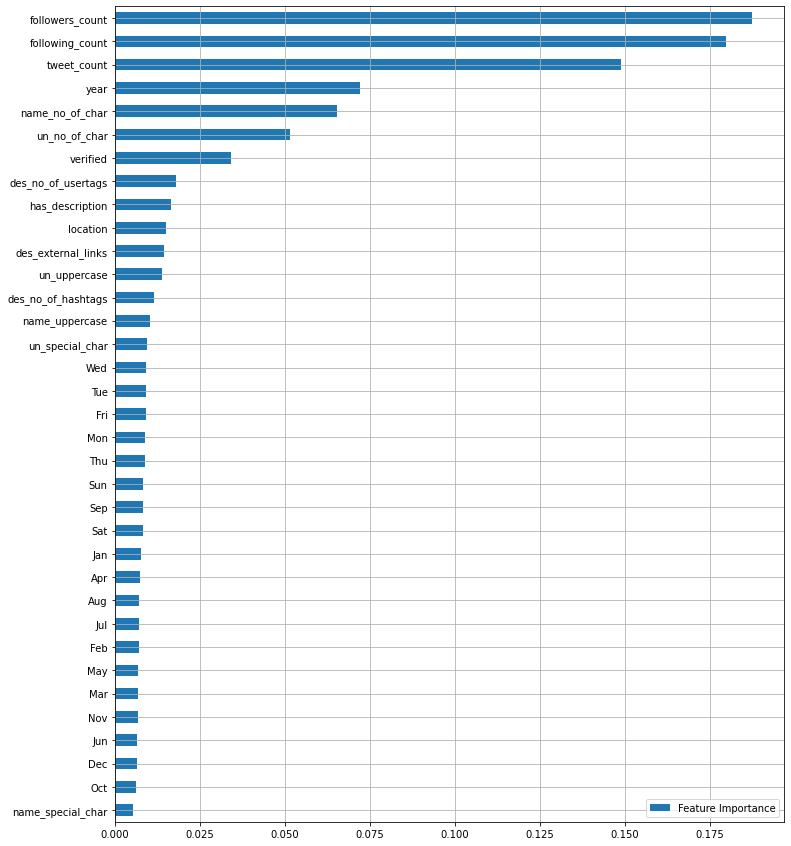

In [19]:
feature_chart(feature, "Random Forest")